# Total Pressure Inlet Condition 

In [1]:
using Ferrite
using SparseArrays
using LinearAlgebra # provides mul! 
using UnPack # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl
using WriteVTK
using Plots 

## Section 1: Introduction 

The <b>total pressure inlet condition</b> imposes that on the inlet patch $p_{total} = p_{static} + p_{dynamic}$. We recall that only total quantities are conserved. The condition implies that 
$p_{total} = p_{static} + 0.5 \, \rho \, \vec{v} \cdot \vec{v}$, where $p_{static}$ is the pressure solved for in the Navier-Stokes model. Physically speaking, we have that 

<b>Initial Pressure Difference</b>: If the inlet pressure (total pressure) is higher than the initial pressure inside the vessel, fluid flows into the vessel, increasing the internal pressure. This flow is driven by the pressure gradient between the inlet and the pressure inside the reservoir.
What happens next:

<b>Pressure Equilibration</b>: As fluid enters the closed vessel, the inner static pressure rises. For incompressible flow (or compressible flow within a rigid reservoir), the pressure increase is directly related to the added mass. For compressible fluids, density changes also contribute to pressure buildup and must be taken into account.

<b>Dynamic to Static Pressure Transition</b>: The inlet's total pressure includes static and dynamic components. As the vessel's internal static pressure approaches the inlet's total pressure, the dynamic pressure (velocity-dependent term) diminishes, slowing the flow.

<b>Steady-State Condition</b>: When the vessel's static pressure equals the inlet's total pressure, the pressure gradient driving the flow vanishes. At this point, the inflow velocity reduces to zero, and the system reaches a steady state with no net flow. See also, [this video](https://www.youtube.com/watch?v=Er2j5Kq17as)

The total pressure inlet condition is standard in various packages. These include 
[Fluent Users Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm) and [OpenFoam Example](https://doc.openfoam.com/2306/tools/processing/boundary-conditions/rtm/derived/inletOutlet/totalPressure/). In this notebook we explore the implementation of this non-linear boundary condition is an existing FEM solver.   

## Section 2: Linear Scalar Diffusion  

### 2.1: Model Problem 

**The Poisson Equation**

$$-\nabla^2 u(\mathbf{x}) = f(\mathbf{x}) \quad \text{on } \Omega$$

Where:
* $\mathbf{x}$ represents the spatial coordinates $(x, y)$ in our 2D case.
* $\nabla^2$ is the Laplacian operator, defined as $\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$. It describes the diffusion or distribution of $u$.
* $f(\mathbf{x})$ is a known source term.


**The Domain and Boundary Conditions (BCs)**

Our computational domain $\Omega$ is a 2D rectangle. To solve the Poisson equation, we must specify boundary conditions (BCs) on the boundary $\partial \Omega$ of this domain. The provided code implements the following conditions:

1.  **Dirichlet BC**

    While the code specifically sets a condition on the "left" side, for a scalar diffusion problem like the Poisson equation, the other boundaries often implicitly have Neumann (zero-flux) boundary conditions if no other BCs are explicitly defined. This means no quantity is entering or leaving through these boundaries by diffusion.

    Using a Dirichlet boundary condition (such as $u=10.0$ on `left_patch`) is sufficient to make the Poisson problem non-singular and guarantee a unique solution for $u$.

    $$u(\mathbf{\text{left patch}}) = 10.0$$

2.  **Mean Average Constraint**

Dirichlet homogeneous conditions on three sides (top, bottom, right) fix the value of $u$ to zero, preventing trivial solutions.

Instead of fixing a point value, we impose a *mean* value on the remaining left boundary. This provides the necessary "anchor" for the solution, determining the overall level of $u$ on that specific boundary without strictly fixing every point. This is often more physically realistic in certain scenarios than a uniform Dirichlet condition.
    $$\frac{1}{L_{\text{left}}} \int_{\text{left boundary}} u \, ds = 10.0$$

This combination avoids the singularity issues that arise from imposing Neumann conditions on all boundaries (solution unique up to a constant) or Dirichlet homogeneous on all boundaries (trivial solution $u=0$).

3. **Lagrange Multipliers**

For the linear constraints using this time Lagrange multipliers (as opposed to AffineConstraints that Ferrite already provides), I would need to look into the details. (For now, see [Lagrangian multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier). 

### 2.2: Numerical Solution

In [12]:
?generate_grid

search: generate_grid @generated Base.Generator



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


In [13]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

In [14]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)

    assembler = start_assemble(K, f)

    for cell in CellIterator(dh)

        fill!(Ke, 0)
        fill!(fe, 0)

        Ferrite.reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)

            for i in 1:n_basefuncs
                v = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                fe[i] += v * dΩ
                #fe[i] += 0 ---------------------------------------------------------
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

assemble_K! (generic function with 1 method)

In [17]:
function setup_mean_constraint(dh, fvu)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(getfacetset(dh.grid, "left"))
    # Allocate buffers
    range_u = dof_range(dh, :u)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_u = view(element_dofs, range_u)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only
    Ce = zeros(1, length(range_u)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvu, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(cvu, qp)
            for i in 1:getnbasefunctions(fvu)
                Ce[1, i] += shape_value(fvu, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_u, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int, Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        10.0,
    )
    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

In [16]:
function mypostprocess(u, dh, cvu, nels)

    numcells = nels[1]*nels[2]
    area = zeros(numcells)
    myu  = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))

        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellu = 0 
    
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            celluq = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellu += celluq*dΩ
        end

        area[cell_num] = cellarea
        myu[cell_num]  = cellu
    
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return area, myu2d 
end 

mypostprocess (generic function with 1 method)

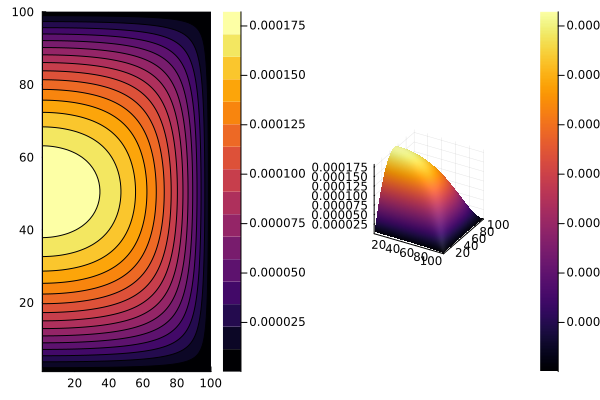

In [45]:
# Boundary conditions part: Dirichlet BC for the velocity at the top lid 
left_patch = getfacetset(dh.grid, "left")
if (false) # --------------------------------------------------------------------------------
    dbc1 = Dirichlet(:u, left_patch, (x,t) ->  10. )
else 
    dbc1 = setup_mean_constraint(dh, fvu)
end 
add!(ch, dbc1)

# Add Homogeneous Dirichlet Boundary conditions ---------------------------------------------
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")

# Create Dirichlet BCs for u=0 on these patches
dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

# Add these new Dirichlet BCs to the ConstraintHandler
add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

K = allocate_matrix(dh,ch);
M = allocate_matrix(dh,ch);
f = zeros(ndofs(dh));

K, f = assemble_K!(K, f, cvu, dh);
apply!(K, f, ch)
u = K \ f;

VTKGridFile("diffusion", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

area, myu2d = mypostprocess(u, dh, cvu, nels)
p1 = contour(myu2d', fill=true)
p2 = surface(myu2d', fill=true)
plot(p1,p2, layout=(1,2))

## Section 3 : Non linear Scalar Diffusion  

### 3.1 Model Problem

### 3.2 Solution Approaches    

#### Section 3.2.1 : Penalty Method 

For the non-linear constraints using the [penalty method](https://en.wikipedia.org/wiki/Penalty_method), it suffices to add a boundary term to the weak form. More specifically, one adds to the weak form the term p $\int_{\Gamma_{inlet}} [u^2 - 1] \, v \, d\Gamma$, where p is a weighting factor and v is the test function. The weighting factor p is initially zero and increases (to give more weight to the constraint to be imposed) as convergence is obtained. In a transient solution process, the weighting parameter p can be scaled with time. 

For the implementation of integrals over the boundary, the incompressible elasticity tutorial provides a good example. Look for the comment “We integrate the Neumann boundary using the FacetValues.” This part of the weak form needs to be updated with time. This is similar to the update of the non-linear part of the Jacobian in the incompressible Navier-Stokes tutorial. 

### 3.3 Numerical Solutions

In [15]:
?generate_grid

search: generate_grid @generated Base.Generator



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


In [16]:
# grid = generate_grid(Quadrilateral, (100, 100));
nelem = 100 
nels  = (nelem, nelem) # number of elements in each spatial direction
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu       = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

ch = ConstraintHandler(dh);

# 2. Conditions aux limites de Dirichlet homogènes (pas de changement ici)
top_patch = getfacetset(dh.grid, "top")
bottom_patch = getfacetset(dh.grid, "bottom")
right_patch = getfacetset(dh.grid, "right")
left_patch = getfacetset(dh.grid, "left") # Définir le patch gauche aussi !

dbc_top = Dirichlet(:u, top_patch, (x,t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_patch, (x,t) -> 0.0)
dbc_right = Dirichlet(:u, right_patch, (x,t) -> 0.0)

add!(ch, dbc_top)
add!(ch, dbc_bottom)
add!(ch, dbc_right)

close!(ch);

In [17]:
# 3. Fonction d'assemblage modifiée pour Newton-Raphson (Jacobien et Résidu)
function assemble_jacobian_residual!(K::SparseMatrixCSC, R::Vector, cellvalues::CellValues, facetvalues::FacetValues, dh::DofHandler, u_current::Vector, p_penalty::Float64)

    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs) # Matrice élémentaire Jacobienne
    re = zeros(n_basefuncs)             # Vecteur résiduel élémentaire

    assembler = start_assemble(K, R) # Assure que K et R sont réinitialisés

    for cell in CellIterator(dh)

        fill!(Ke, 0.0)
        fill!(re, 0.0)

        Ferrite.reinit!(cellvalues, cell)
        
        # Extraire les valeurs de u_current pour les DOFs de la cellule
        # C'est la solution de l'itération précédente pour l'évaluation des termes non-linéaires
        cell_u_current = u_current[celldofs(cell)]

        # ----- Intégration sur le domaine (termes de diffusion et de source) -----
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)
            
            # --- Résidu (R) ---
            # Terme de diffusion: ∇u ⋅ ∇v. Le résidu est R = (∇u_old ⋅ ∇v)
            # Puisque le solveur linéaire résout J * du = -R, on met le signe - ici
            # Pour l'équation de Poisson, R = integral(∇u⋅∇v - fv) dΩ + ...
            # Donc, ici, on ajoute - (∇u_current ⋅ ∇v) et -(-f_val * v) = + f_val * v
            
            ∇u_current_q = function_gradient(cellvalues, q_point, cell_u_current) # ∇u évalué avec u_current
            
            # Terme de source f (par exemple, f = 1.0 partout, ou une fonction f_source(x))
            f_val = 1.0 # Remplace par ta fonction de source si elle est variable
            # x_coords = getcoordinates(cellvalues, q_point) # Si f dépend de x
            # f_val = f_source(x_coords)

            for i in 1:n_basefuncs
                ∇v = shape_gradient(cellvalues, q_point, i)
                v  = shape_value(cellvalues, q_point, i)
                
                # Contribution au résidu : ∇u_current ⋅ ∇v - f_val * v
                re[i] += (∇u_current_q ⋅ ∇v - f_val * v) * dΩ 
            end

            # --- Jacobien (K) ---
            # Dérivée du terme de diffusion: (∇δu ⋅ ∇v)
            # C'est le terme linéaire standard de la matrice de rigidité
            for i in 1:n_basefuncs
                ∇v_i = shape_gradient(cellvalues, q_point, i)
                for j in 1:n_basefuncs
                    ∇u_j = shape_gradient(cellvalues, q_point, j) # C'est le ∇(phi_j) pour delta u
                    Ke[i, j] += (∇v_i ⋅ ∇u_j) * dΩ
                end
            end
        end

        # ----- Intégration sur la frontière (terme de pénalité) -----
        # On va chercher les facettes de la cellule qui sont sur le "left_patch"
        for face in 1:nfacets(cell)
            if (cellid(cell), face) ∈ left_patch # Vérifie si la facette est sur le patch gauche
                
                Ferrite.reinit!(facetvalues, cell, face)
                
                for q_point_facet in 1:getnquadpoints(facetvalues)
                    dΓ = getdetJdV(facetvalues, q_point_facet)
                    
                    # Valeur de u_current au point de quadrature de la facette
                    u_q_current = function_value(facetvalues, q_point_facet, cell_u_current)

                    for i in 1:n_basefuncs
                        v_i = shape_value(facetvalues, q_point_facet, i)
                        
                        # --- Contribution au résidu du terme de pénalité : p * (u_q_current^2 - 1) * v_i ---
                        re[i] += p_penalty * (u_q_current^2 - 1.0) * v_i * dΓ

                        # --- Contribution au Jacobien du terme de pénalité : p * 2 * u_q_current * v_i * u_trial_j ---
                        for j in 1:n_basefuncs
                            u_trial_j = shape_value(facetvalues, q_point_facet, j) # shape function phi_j
                            Ke[i, j] += p_penalty * 2.0 * u_q_current * v_i * u_trial_j * dΓ
                        end
                    end
                end
            end
        end
        
        # Assembler les matrices et vecteurs élémentaires dans les matrices globales
        assemble!(assembler, celldofs(cell), Ke, re)
    end
    return K, R
end


assemble_jacobian_residual! (generic function with 1 method)

In [18]:
# Fonction pour la résolution (Boucle Newton + Boucle Pénalité)
function solve_nonlinear_poisson(dh::DofHandler, ch::ConstraintHandler, cvu::CellValues, fvu::FacetValues, left_patch)
    
    ndofs_total = ndofs(dh)
    u = ones(ndofs_total) # Estimation initiale pour u 

    # Paramètres du solveur de pénalisation
    p_penalty_initial = 1.0e-3 # Commencer avec un petit p
    p_penalty_max = 1.0e6     # Valeur max pour p
    p_increase_factor = 10.0  # Facteur d'augmentation de p

    # Paramètres de Newton-Raphson
    newton_tol = 1.0e-6
    max_newton_iter = 20

    current_p_penalty = p_penalty_initial
    
    for penalty_iter in 1:5 # Loop pour augmenter p_penalty (ex: 5 étapes)
        @info "--- Penalty Iteration $(penalty_iter), p_penalty = $(current_p_penalty) ---"
        
        for newton_iter in 1:max_newton_iter
            K = allocate_matrix(dh) # Crée une matrice creuse vide
            R = zeros(ndofs_total)          # Vecteur résiduel

            # Assemblage de la Jacobienne (K) et du Résidu (R)
            assemble_jacobian_residual!(K, R, cvu, fvu, dh, u, current_p_penalty)

            # Application des conditions de Dirichlet
            # Le résidu doit être mis à zéro aux DOFs contraints pour les équations correspondantes
            # Les lignes et colonnes de K correspondant aux DOFs contraints sont modifiées
            Ferrite.apply!(K, R, ch) 
            
            # Résolution du système linéaire pour la correction Δu
            # On résout J * Δu = -R (d'où le -R ici)
            Δu = K \ R 
            
            # Mise à jour de la solution
            u .+= Δu

            # Vérification de la convergence de Newton
            residual_norm = norm(R[Ferrite.free_dofs(ch)]) # Norme du résidu sur les DOFs libres
            delta_u_norm = norm(Δu[Ferrite.free_dofs(ch)]) # Norme de la correction
            
            @info "  Newton Iteration $(newton_iter): ||R|| = $(residual_norm), ||Δu|| = $(delta_u_norm)"

            if residual_norm < newton_tol
                @info "  Newton converged in $(newton_iter) iterations."
                break
            elseif newton_iter == max_newton_iter
                @warn "  Newton did NOT converge within max iterations for p_penalty = $(current_p_penalty)."
            end
        end

        # Préparation pour la prochaine itération de pénalité
        current_p_penalty *= p_increase_factor
        if current_p_penalty > p_penalty_max
            current_p_penalty = p_penalty_max
        end
    end
    
    return u
end

# --- Exécution principale ---
final_u = solve_nonlinear_poisson(dh, ch, cvu, fvu, left_patch);


[ Info: --- Penalty Iteration 1, p_penalty = 0.001 ---
[ Info:   Newton Iteration 1: ||R|| = 0.03964996847413639, ||Δu|| = 26.636313926545103
[ Info:   Newton Iteration 2: ||R|| = 0.0792988209838429, ||Δu|| = 53.28126056427856
[ Info:   Newton Iteration 3: ||R|| = 0.1585932278343213, ||Δu|| = 106.59711613812719
[ Info:   Newton Iteration 4: ||R|| = 0.31716919843050384, ||Δu|| = 213.33312801126013
[ Info:   Newton Iteration 5: ||R|| = 0.6342725864317499, ||Δu|| = 427.22600297461406
[ Info:   Newton Iteration 6: ||R|| = 1.26830807085982, ||Δu|| = 856.7249335208577
[ Info:   Newton Iteration 7: ||R|| = 2.535883278210337, ||Δu|| = 1722.8235607714698
[ Info:   Newton Iteration 8: ||R|| = 5.070667737501254, ||Δu|| = 3485.5799750139527
[ Info:   Newton Iteration 9: ||R|| = 10.153526036325985, ||Δu|| = 7153.87960490097
[ Info:   Newton Iteration 10: ||R|| = 20.526841433449754, ||Δu|| = 15305.788307335162
[ Info:   Newton Iteration 11: ||R|| = 44.2938346901816, ||Δu|| = 40869.33772931925
[ Info